# Credit Card : Churn Propension 
 - <b>Feature analysis</b>
 - <b>Feature selection</b>

<b>BU Doc Reference:</b> https://docs.google.com/document/d/1Zk_chGs5UNajPjJQd_6pab_GJw11z_vN8AKl16B3Qtw/edit

<b>Business Problem:</b> How to identify and engage customers with a high Churn propensity with the goal of keeping them on active base.


Different models were tested in order to analyze the Feature importance of potential variables for card churn, especially characteristics related to the frequency and average financial value of transactions

In [ ]:
# Necessary frameworks
import os
try:
    !pip install -r requirements.txt > /dev/null
    print("All instalations complete")
except:
    print("Error on installing packages")
os._exit(00)

In [1]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, plot_roc_curve
from sklearn import metrics
import lightgbm as lgbm
import catboost
import xgboost
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import awswrangler as wr

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import kstest
from scipy.stats import mannwhitneyu
from cliffs_delta import cliffs_delta
from scipy.stats import chi2_contingency

In [2]:
# Setting up number formating 

pd.set_option('display.float_format', '{:.2g}'.format)

In [2]:
# Reading database

df = wr.s3.read_parquet('s3://neon-datascience-sandbox/churn-cartoes/main')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066132 entries, 0 to 2066131
Data columns (total 18 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   clientid                        Int64  
 1   ticket_mean_value               float64
 2   total_transactions              Int64  
 3   data_min                        string 
 4   data_max                        string 
 5   time_diff                       Int64  
 6   mean_time_between_transactions  float64
 7   presumedincome                  float64
 8   age                             float64
 9   ageneon                         Int64  
 10  GH_VL                           float64
 11  tempo_sem_transacao             Int64  
 12  churn_flag                      Int64  
 13  limitecreditototal              float64
 14  debitoautomatico                boolean
 15  limitecreditodisponivel         float64
 16  diasatraso                      float64
 17  ACCOUNT_BALANCE_VL         

## EDA: Pre-modelling analysis

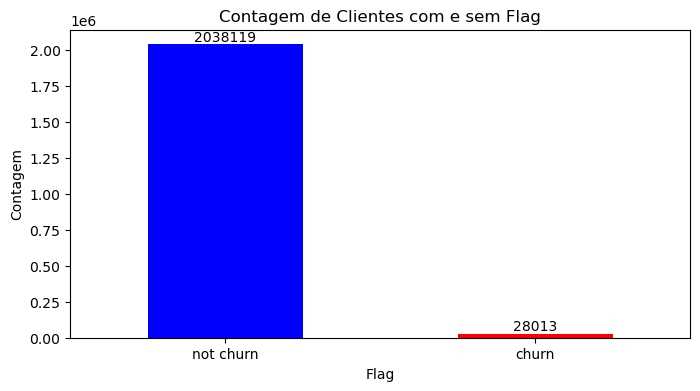

In [3]:
# Diferença entre clientes que tiveram e não tiveram churn

count_flag = df.churn_flag.value_counts()

plt.figure(figsize=(8, 4))
ax = count_flag.plot(kind='bar', color=['blue', 'red'])
# Personalizar o gráfico
plt.title('Contagem de Clientes com e sem Flag')
plt.xlabel('Flag')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.xticks([0, 1], ['not churn', 'churn'])

# Adicionar valores acima das barras
for i, v in enumerate(count_flag):
    ax.text(i, v + 10, str(v), color='black', ha='center', va='bottom')
# Exibir o gráfico
plt.show()

Do total de clientes que transacionaram entre as datas do teste, 1,37% entraram em churn (entre 30 e 60 dias sem transações)

Equilibrando a amostra para a mesma quantidade clientes com churn_flag = 1 e 0.

In [4]:
df_temp_0 = df[df['churn_flag'] == 0]
df_temp_sample_0 = df_temp_0.sample(n = len(df[df['churn_flag'] == 1]), random_state = 42)
df_temp_1 = df[df['churn_flag'] == 1]
df = pd.concat([df_temp_sample_0, df_temp_1])

Para os valores com NA, foi feito o preechimento dos mesmos com a média.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56026 entries, 826001 to 2066092
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   clientid                        56026 non-null  Int64  
 1   ticket_mean_value               56026 non-null  float64
 2   total_transactions              56026 non-null  Int64  
 3   data_min                        56026 non-null  string 
 4   data_max                        56026 non-null  string 
 5   time_diff                       56026 non-null  Int64  
 6   mean_time_between_transactions  56026 non-null  float64
 7   presumedincome                  54566 non-null  float64
 8   age                             56022 non-null  float64
 9   ageneon                         56026 non-null  Int64  
 10  GH_VL                           55881 non-null  float64
 11  tempo_sem_transacao             28013 non-null  Int64  
 12  churn_flag               

In [6]:
# Convertendo os valores booleanos para float64

df.debitoautomatico.replace({False: 0, True: 1, np.nan: 0}, inplace=True)


In [7]:
for column in df[['ticket_mean_value', 
                  'total_transactions', 
                  'time_diff', 
                  'mean_time_between_transactions',
                  'presumedincome', 
                  'age', 
                  'ageneon', 
                  'GH_VL', 
                  'limitecreditototal', 
                  'limitecreditodisponivel', 
                  'diasatraso', 
                  'ACCOUNT_BALANCE_VL']].columns:
    df[column].fillna(np.mean(df[column]), inplace = True)

In [8]:
df.churn_flag.value_counts()

0    28013
1    28013
Name: churn_flag, dtype: Int64

## 1. Correlation Analysis

In [105]:
df.columns

Index(['clientid', 'ticket_mean_value', 'total_transactions', 'data_min',
       'data_max', 'time_diff', 'mean_time_between_transactions',
       'presumedincome', 'age', 'ageneon', 'GH_VL', 'tempo_sem_transacao',
       'churn_flag', 'limitecreditototal', 'debitoautomatico',
       'limitecreditodisponivel', 'diasatraso', 'ACCOUNT_BALANCE_VL'],
      dtype='object')

In [9]:
correlation_matrix = df[['ticket_mean_value', 
                  'total_transactions', 
                  'time_diff', 
                  'mean_time_between_transactions',
                  'presumedincome', 
                  'age', 
                  'ageneon', 
                  'GH_VL', 
                  'limitecreditototal', 
                  'limitecreditodisponivel',
                  'debitoautomatico',
                  'diasatraso', 
                  'ACCOUNT_BALANCE_VL']].corr()

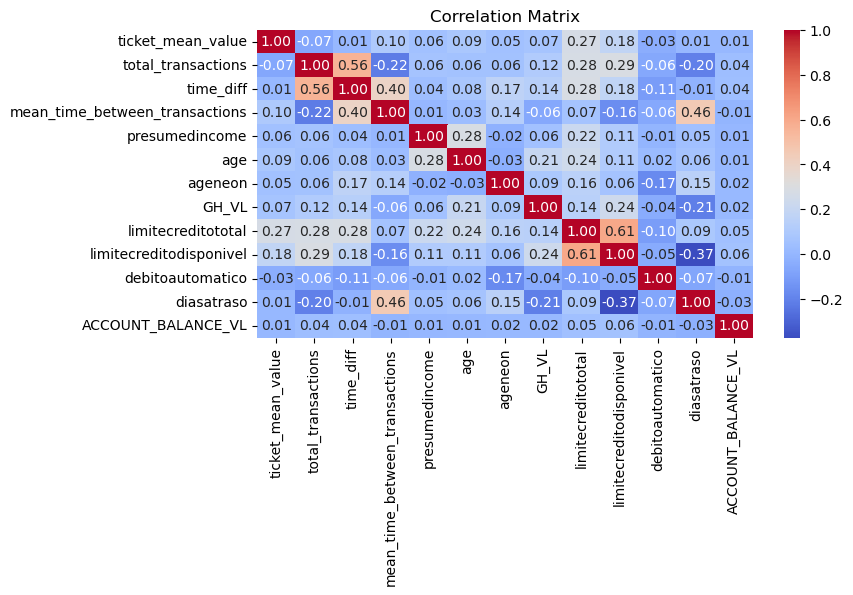

In [10]:
plt.figure(figsize = (8, 4))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title("Correlation Matrix")
plt.show()

Como decisões da análise de correlação:

 - Remover timediff que é uma variável proxy para calcular mean_time_between_transactions, e também se correlaciona muito com o total de transações.
 - Apesar da considerável correlação, mantivemos tanto limitecreditototal quanto limitecreditodisponivel


In [11]:
# Lista de features e do target

features = ['ticket_mean_value', 
            'total_transactions', 
            'mean_time_between_transactions',
            'presumedincome', 
            'age', 
            'ageneon', 
            'GH_VL', 
            'limitecreditototal', 
            'limitecreditodisponivel',
            #'debitoautomatico',
            'diasatraso', 
            'ACCOUNT_BALANCE_VL']
target = ['churn_flag']

features_and_target = ['ticket_mean_value', 
                        'total_transactions', 
                        'mean_time_between_transactions',
                        'presumedincome', 
                        'age', 
                        'ageneon', 
                        'GH_VL', 
                        'limitecreditototal', 
                        'limitecreditodisponivel',
                        #'debitoautomatico',
                        'diasatraso', 
                        'ACCOUNT_BALANCE_VL',
                        'churn_flag']

In [12]:
df = df[features_and_target]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56026 entries, 826001 to 2066092
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ticket_mean_value               56026 non-null  float64
 1   total_transactions              56026 non-null  Int64  
 2   mean_time_between_transactions  56026 non-null  float64
 3   presumedincome                  56026 non-null  float64
 4   age                             56026 non-null  float64
 5   ageneon                         56026 non-null  Int64  
 6   GH_VL                           56026 non-null  float64
 7   limitecreditototal              56026 non-null  float64
 8   limitecreditodisponivel         56026 non-null  float64
 9   diasatraso                      56026 non-null  float64
 10  ACCOUNT_BALANCE_VL              56026 non-null  float64
 11  churn_flag                      56026 non-null  Int64  
dtypes: Int64(3), float64(9)
m

## 2. Statistical Analysis

Helper Functions

In [14]:
def evaluate_normality(dataframe, cols):
    
    for col in cols:
        stat, p = kstest(dataframe[col], 'norm')
        
        if p > 0.05:
            print('{:<30s} Probably Gaussian, p-value: {:>4}'.format(col, p))
        else:
            print('{:<30s} Probably not Gaussian, p-value: {:>4}'.format(col, p))

In [16]:
def test_binary(dataframe, cols, main_flag):
    
    save_data = list()
    
    for col in cols:
        contigency = pd.crosstab(dataframe[col], dataframe[main_flag])
        p_value = chi2_contingency(contigency)[1]
        
        if p_value > 0.05:
            print('{:<10s} and {:>4} are independent. P-value {:>4}'.format(col, main_flag, p_value))
        else:
            print('{:<10s} and {:>4} are Related. P-value {:>4}'.format(col, main_flag, p_value))
        
        save_data.append({'feature' : col, 
                'p_value': p_value})
    
    return pd.DataFrame(save_data, index=range(len(save_data)))

In [17]:
def test_not_normal(group1, group2, cols):
    save_data = list()
    for col in cols:
        p_value  = mannwhitneyu(group1[col].dropna(), group2[col].dropna())[1]
        cliff = cliffs_delta(group1[col].dropna(), group2[col].dropna())[1]

        save_data.append({'feature' : col, 
                'median_group1': np.median(group1[col].dropna()),
               'median_group2': np.median(group2[col].dropna()),
                'p_value': p_value,
               'cliffs_delta': cliff})
    return pd.DataFrame(save_data, index=range(len(save_data)))

Testes estatísticos

In [18]:
# Testando a normalidade das features

evaluate_normality(df.astype('float64'), features)

ticket_mean_value              Probably not Gaussian, p-value:  0.0
total_transactions             Probably not Gaussian, p-value:  0.0
mean_time_between_transactions Probably not Gaussian, p-value:  0.0
presumedincome                 Probably not Gaussian, p-value:  0.0
age                            Probably not Gaussian, p-value:  0.0
ageneon                        Probably not Gaussian, p-value:  0.0
GH_VL                          Probably not Gaussian, p-value:  0.0
limitecreditototal             Probably not Gaussian, p-value:  0.0
limitecreditodisponivel        Probably not Gaussian, p-value:  0.0
diasatraso                     Probably not Gaussian, p-value:  0.0
ACCOUNT_BALANCE_VL             Probably not Gaussian, p-value:  0.0


Nenhum dos features tem distribuição normal

In [19]:
# Teste de diferenças entre as features para os clientes que entraram em churn e não entraram em churn

churn_0 = df[df['churn_flag'] == 0].astype('float64')
churn_1 = df[df['churn_flag'] == 1].astype('float64')
test_not_normal(churn_0, churn_1, features)

,feature,median_group1,median_group2,p_value,cliffs_delta
0,ticket_mean_value,55.4445,37.795000,0.000000e+00,small
1,total_transactions,10.0000,2.000000,0.000000e+00,large
2,mean_time_between_transactions,3.0000,0.666667,1.548850e-295,small
3,presumedincome,1284.7900,1240.310000,1.393273e-16,negligible
4,age,33.0000,31.000000,2.808462e-59,negligible
5,ageneon,24.0000,21.000000,2.279564e-68,negligible
6,GH_VL,6.0000,5.000000,0.000000e+00,small
7,limitecreditototal,1012.0000,490.000000,0.000000e+00,small
8,limitecreditodisponivel,567.5000,10.260000,0.000000e+00,large
9,diasatraso,0.0000,3.000000,0.000000e+00,small


 Diferenças medidas entre os grupos com e sem churn:
 
 - Grande diferença: limitecreditodisponivel, total_transactions
 - Média diferença: ACCOUNT_BALANCE_VL
 - Pequena diferença: ticket_mean_value, mean_time_between_transactions, GH_VL, limitecreditototal, diasatraso
 - Demais features sem diferenças perceptíveis

In [20]:
test_binary(df, features, 'churn_flag')

ticket_mean_value and churn_flag are Related. P-value 1.9196607491005142e-133
total_transactions and churn_flag are Related. P-value  0.0
mean_time_between_transactions and churn_flag are Related. P-value  0.0
presumedincome and churn_flag are Related. P-value 0.0008143368294528662
age        and churn_flag are Related. P-value 1.2445573370878374e-73
ageneon    and churn_flag are Related. P-value 4.227384829524752e-152
GH_VL      and churn_flag are Related. P-value  0.0
limitecreditototal and churn_flag are Related. P-value 7.885465891028596e-281
limitecreditodisponivel and churn_flag are Related. P-value 5.19248408917244e-103
diasatraso and churn_flag are Related. P-value  0.0
ACCOUNT_BALANCE_VL and churn_flag are Related. P-value 3.731498695238465e-75


,feature,p_value
0,ticket_mean_value,1.919661e-133
1,total_transactions,0.000000e+00
2,mean_time_between_transactions,0.000000e+00
3,presumedincome,8.143368e-04
4,age,1.244557e-73
5,ageneon,4.227385e-152
6,GH_VL,0.000000e+00
7,limitecreditototal,7.885466e-281
8,limitecreditodisponivel,5.192484e-103
9,diasatraso,0.000000e+00


Todas as features estão correlacionadas com a flag de churn

## 3. Model performance test

In [21]:

X = df[features].astype('float64')
y = df[target].astype('float64')
y = y.values.ravel()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'Random Forest': RandomForestClassifier(random_state=42)
}
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    results.append({'Model': model_name, 'Accuracy': accuracy, 'Classification Report': classification_rep})

df_results = pd.DataFrame(results)

print(df_results)

[LightGBM] [Info] Number of positive: 22393, number of negative: 22427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1955
[LightGBM] [Info] Number of data points in the train set: 44820, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499621 -> initscore=-0.001517
[LightGBM] [Info] Start training from score -0.001517
           Model  Accuracy                              Classification Report
0       LightGBM  0.885329                precision    recall  f1-score   ...
1        XGBoost  0.884169                precision    recall  f1-score   ...
2       CatBoost  0.887739                precision    recall  f1-score   ...
3  Random Forest  0.879797                precision    recall  f1-score   ...


## 4. Feature Importance 

Usando o lightgbm para a feature importance, pois foi um dos modelos com melhor performance

In [23]:
base_treino = df.sample(frac=0.8,random_state=0)
base_teste = df.drop(base_treino.index)

In [24]:
Xtrain = base_treino[features].astype('float64')
ytrain = base_treino[target].astype('float64')

Xtest = base_teste[features].astype('float64')
ytest = base_teste[target].astype('float64')

In [25]:
model_lgbm = lgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model_lgbm.fit(Xtrain,ytrain, eval_set=[(Xtest,ytest),(Xtrain,ytrain)], eval_metric='auc')

/opt/conda/envs/datalake/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 22455, number of negative: 22366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1948
[LightGBM] [Info] Number of data points in the train set: 44821, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500993 -> initscore=0.003971
[LightGBM] [Info] Start training from score 0.003971


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [29]:
print('Training accuracy {:.4f}'.format(model_lgbm.score(Xtrain,ytrain)))
print('Testing accuracy {:.4f}'.format(model_lgbm.score(Xtest,ytest)))
print(metrics.classification_report(ytest,model_lgbm.predict(Xtest)))

Training accuracy 0.8984
Testing accuracy 0.8835
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88      5647
         1.0       0.86      0.91      0.89      5558

    accuracy                           0.88     11205
   macro avg       0.88      0.88      0.88     11205
weighted avg       0.88      0.88      0.88     11205



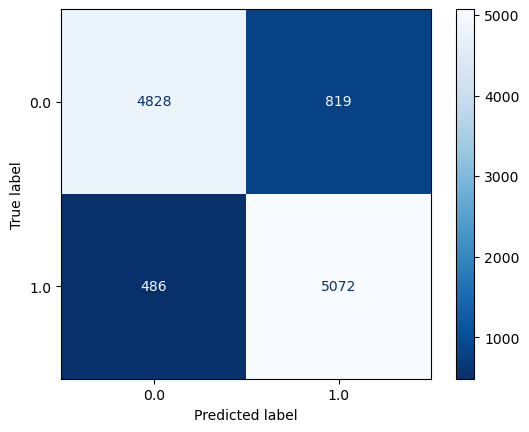

In [30]:
metrics.plot_confusion_matrix(model_lgbm,Xtest,ytest,cmap='Blues_r')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

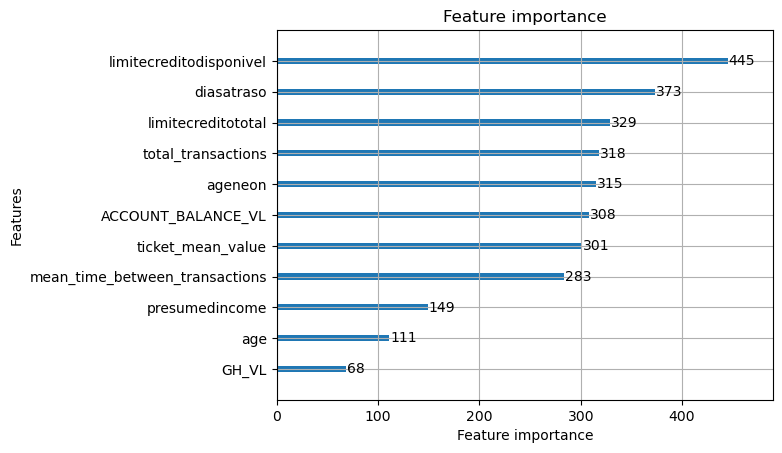

In [31]:
lgbm.plot_importance(model_lgbm)

As fetures mais importantes para que o modelo performe eficientemente são:
- limitecreditodisponivel
- diasatraso
- limitecredtototal
- total_transactions
- ageneon
- ACCOUNT_BALANCE_VL
- ticket_mean_value
- mean_time_between_transactions

E considerando que estatisticamente todas as features se relacional com a churn_flag, é seguro afirmar que, para efeito de negócio essas features elencadas são importantes para prever se o cliente continuará utilizando o cartão Neon.

/opt/conda/envs/datalake/lib/python3.8/site-packages/lightgbm/plotting.py:381: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

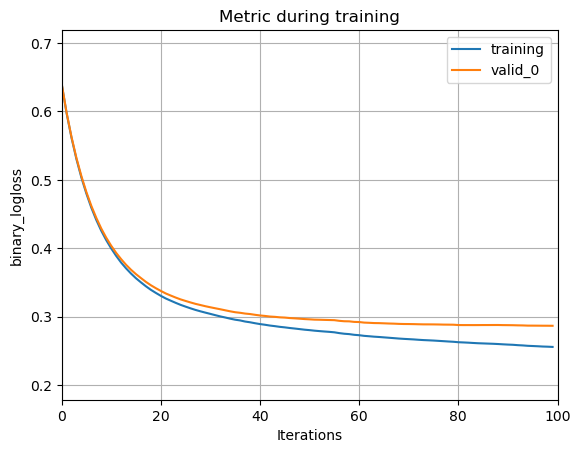

In [32]:
lgbm.plot_metric(model_lgbm)

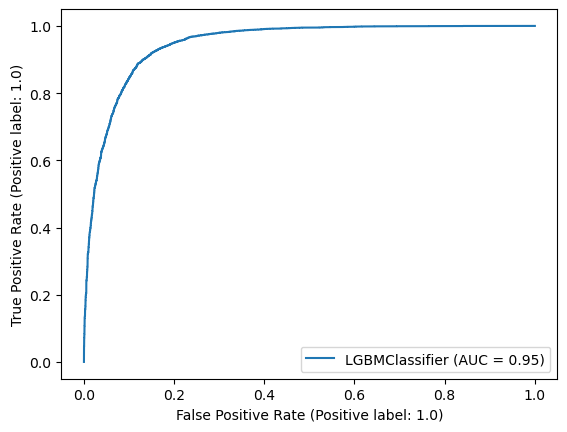

In [34]:
plot_roc_curve(model_lgbm, Xtest, ytest)

<AxesSubplot:>

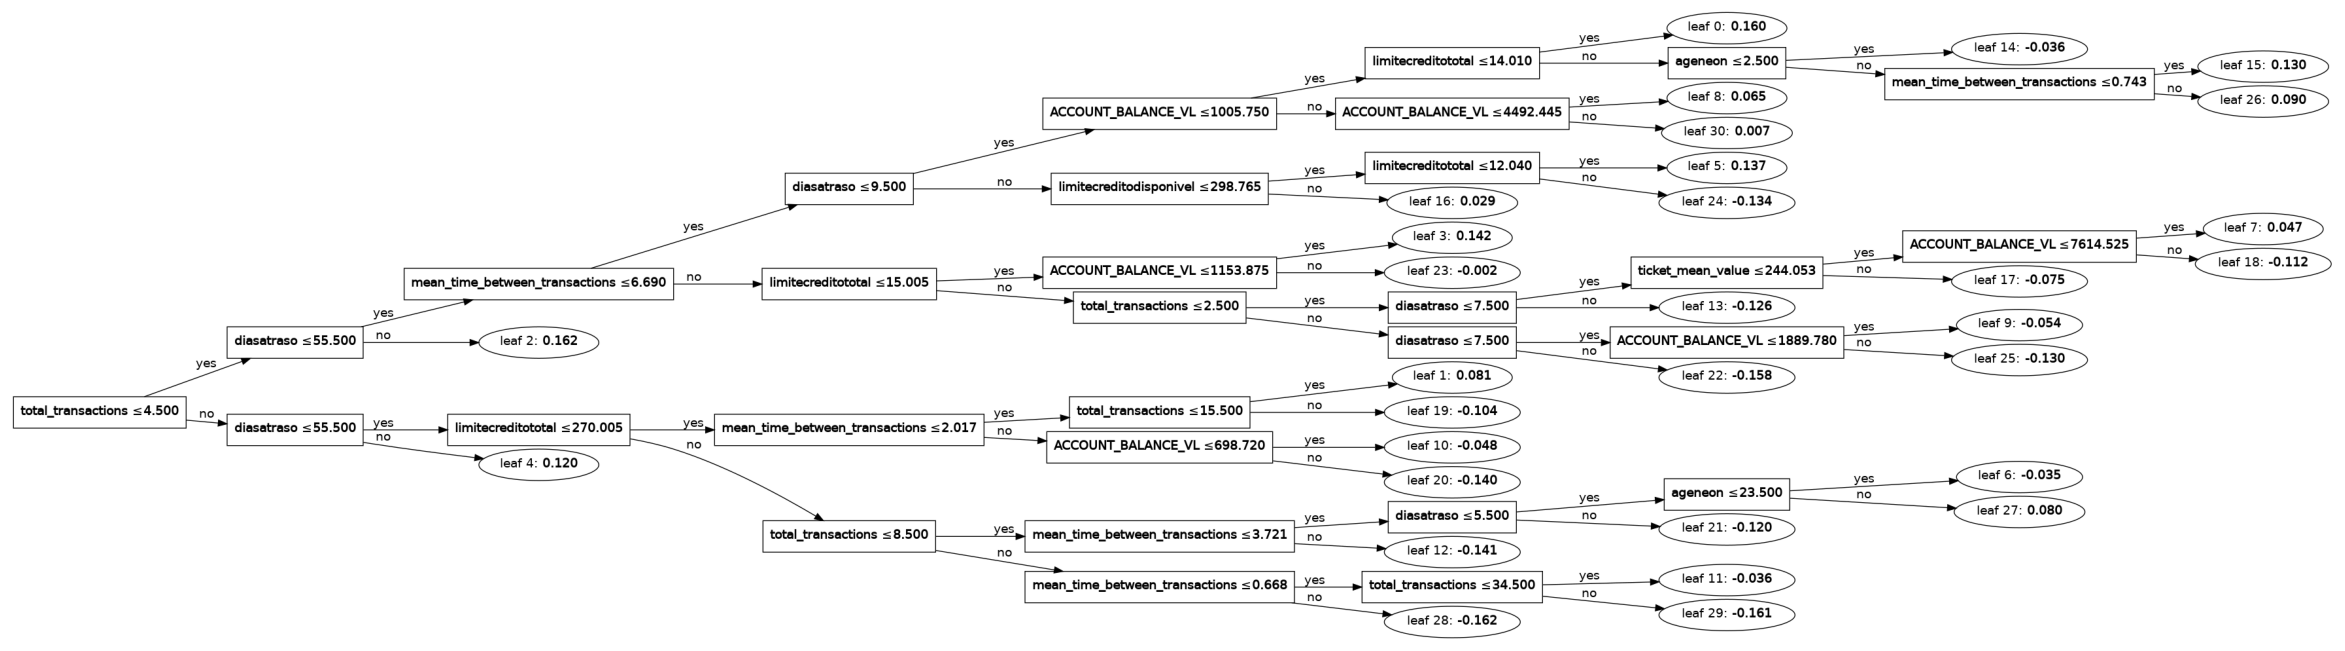

In [33]:
lgbm.plot_tree(model_lgbm,figsize=(30,40))

## 5. Análise preliminar dos resultados

A análise dos resultados do modelo de propensão a churn de cartão de crédito mostra o desempenho do modelo nas métricas de avaliação, o que nos permite avaliar sua eficácia em prever a rotatividade de clientes. Vamos examinar cada métrica:

1. **Training Accuracy (Acurácia no Treinamento): 0.8984**
   - A acurácia no treinamento indica a proporção de previsões corretas feitas pelo modelo nos dados de treinamento.
   - Uma acurácia de 89.84% no treinamento sugere que o modelo foi capaz de se ajustar bem aos dados de treinamento e fazer previsões precisas na amostra em que foi treinado.

2. **Testing Accuracy (Acurácia no Teste): 0.8835**
   - A acurácia no teste indica a proporção de previsões corretas feitas pelo modelo nos dados de teste, que são independentes dos dados de treinamento.
   - Uma acurácia de 88.35% nos dados de teste é uma métrica positiva, indicando que o modelo mantém um bom desempenho em um conjunto de dados não visto anteriormente.

3. **Precision, Recall e F1-score (Precisão, Recall e F1-score):**
   - Precision (Precisão): A precisão mede a proporção de previsões positivas corretas em relação ao total de previsões positivas feitas pelo modelo. Uma precisão alta indica que o modelo faz poucos falsos positivos.
   - Recall (Recall): O recall mede a proporção de previsões positivas corretas em relação ao total de instâncias positivas reais na amostra. Um recall alto indica que o modelo faz poucos falsos negativos.
   - F1-score: O F1-score é uma métrica que combina precisão e recall em uma única pontuação, sendo útil quando se deseja um equilíbrio entre ambas as métricas.

   Observações:
   - Para a classe 0.0 (clientes que não churnaram), a precisão é de 0.91, o recall é de 0.85 e o F1-score é de 0.88.
   - Para a classe 1.0 (clientes que churnaram), a precisão é de 0.86, o recall é de 0.91 e o F1-score é de 0.89.

   Esses resultados indicam que o modelo tem um bom desempenho tanto na identificação de clientes que não churnaram quanto na identificação daqueles que churnaram. No entanto, é importante observar que o recall é um pouco mais alto para a classe 1.0, o que significa que o modelo tem uma capacidade melhor de identificar clientes que churnaram em comparação com clientes que não churnaram.

4. **Acurácia Ponderada (Weighted Accuracy): 0.88**
   - A acurácia ponderada leva em consideração a distribuição das classes e é uma média ponderada das acurácias individuais para cada classe.
   - Uma acurácia ponderada de 88% indica que o modelo está tendo um bom desempenho global, considerando as proporções de ambas as classes.

Em resumo, o modelo parece ser promissor na previsão de churn de cartão de crédito, com um bom equilíbrio entre precisão e recall para ambas as classes. No entanto, é importante lembrar que a interpretação dessas métricas deve levar em consideração o contexto específico do negócio e as implicações práticas das previsões do modelo. É recomendável monitorar continuamente o desempenho do modelo e ajustá-lo conforme necessário para atender às metas de negócios.